In [38]:
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.formula.api import ols
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, shapiro, levene, kruskal

In [39]:
data = pd.read_csv('data.csv')
data.head()

,Code,Journal,Year,Length,Advocacy,autonomy,care_planning,communication,decision_support,education,...,psychosocial_support,QOL sum,quality_of_care,respect,role_of_family,SDM com,social_support,values,total_kw,total_kw/length
0,0,ACC,2023,113,0,0,0,0,0,0,...,0,1,1,0.0,10,0,0,0,16,0.141593
1,0,ACC,2023,74,0,0,0,7,1,20,...,0,0,2,0.0,0,0,3,5,69,0.932432
2,1,ACC,2022,131,0,0,0,0,1,2,...,0,0,1,0.0,0,0,0,4,37,0.282443
3,2,ACC,2022,108,0,0,3,8,0,13,...,4,4,11,1.0,0,0,4,8,118,1.092593
4,3,ACC,2021,73,0,1,0,0,0,10,...,0,0,4,3.0,0,0,2,4,44,0.602740


In [40]:
# Group by 'Journal' and calculate mean and standard deviation
summary_stats = data.groupby('Journal')['total_kw/length'].agg(['mean', 'std']).reset_index()

# Rename columns for clarity (optional)
summary_stats = summary_stats.rename(columns={'mean': 'Mean_Total_KW_per_Length', 'std': 'STD_Total_KW_per_Length'})

# Calculate the sample size for each group
summary_stats["Sample size"] = data["Journal"].value_counts().values

summary_stats

,Journal,Mean_Total_KW_per_Length,STD_Total_KW_per_Length,Sample size
0,ACC,0.431495,0.419391,89
1,AHA,0.476380,0.505901,67
2,ESC,0.206843,0.382567,58


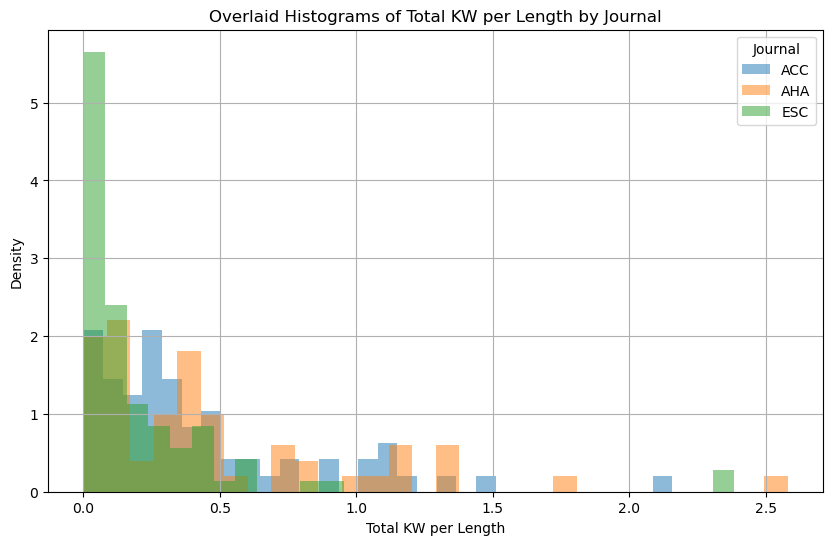

In [41]:
journals = data['Journal'].unique()

plt.figure(figsize=(10, 6))

# Define the number of bins
bins = 30  # Adjust as needed

# Loop through each journal and plot the histogram
for journal in journals:
    subset = data[data['Journal'] == journal]
    plt.hist(subset['total_kw/length'], bins=bins, alpha=0.5, label=journal, density=True)

# Add labels and title
plt.xlabel('Total KW per Length')
plt.ylabel('Density')
plt.title('Overlaid Histograms of Total KW per Length by Journal')
plt.legend(title='Journal')
plt.grid(True)
plt.show()


In [42]:
# Group data by journal
acc = data[data['Journal'] == 'ACC']['total_kw/length']
aha = data[data['Journal'] == 'AHA']['total_kw/length']
esc = data[data['Journal'] == 'ESC']['total_kw/length']

# Check Normality using Shapiro-Wilk test
print("Normality test (Shapiro-Wilk):")
print(f"ACC: {shapiro(acc)}")
print(f"AHA: {shapiro(aha)}")
print(f"ESC: {shapiro(esc)}")

# Check Homogeneity of Variances using Levene's test
stat, p_value = levene(acc, aha, esc)
print(f"Levene's test for equal variances: Stat = {stat}, p-value = {p_value}")

# Perform One-Way ANOVA (valid if normality and homogeneity of variances are satisfied)
# Note: Tests the null hypothesis that two or more groups have the same population mean.
f_stat, p_value = f_oneway(acc, aha, esc)
print(f"ANOVA result: F-statistic = {f_stat}, p-value = {p_value}")

# Perform Kruskal-Wallis H Test (valid if normality and homogeneity of variance are not satisfied)
# Note: Tests the null hypothesis that the population median of all of the groups are equal.
stat, p_value = kruskal(acc, aha, esc)
print(f"Kruskal-Wallis H Test Statistic: {stat}, p-value: {p_value}")

Normality test (Shapiro-Wilk):
ACC: ShapiroResult(statistic=0.8336591946801652, pvalue=3.366399828386168e-07)
AHA: ShapiroResult(statistic=0.8087295772595513, pvalue=3.198667627131e-07)
ESC: ShapiroResult(statistic=0.5231978169606736, pvalue=1.607416749679895e-15)
Levene's test for equal variances: Stat = 3.5156174673746534, p-value = 0.03148289335420419
ANOVA result: F-statistic = 8.626750453113457, p-value = 0.00025047151084777846
Kruskal-Wallis H Test Statistic: 32.49986101390853, p-value: 8.764857294908995e-08
